In [1]:
import cv2
import dlib
import imutils
import numpy as np
from imutils import face_utils
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

/anaconda/envs/py38_default/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [4]:
# define pre-trained landmark detector path
ld_path = '../models/shape_predictor_68_face_landmarks.dat'
# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'

# initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(ld_path)
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)

In [21]:
# load a test image, resize it, and convert it to grayscale
def load_image(path, face_detector, show=False, gray_show=False):
    test_image = cv2.imread(path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    test_image = imutils.resize(test_image, width=500)
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    
    if show:
        plt.imshow(test_image)
        plt.show()
        if gray_show:
            plt.imshow(gray, cmap='gray')
            plt.show()
    
     # detect faces in the grayscale image
    if face_detector == 'dlib':
        rects = detector(gray, 1)
    elif face_detector == 'haar':
        detections = haar_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(100, 100), flags=cv2.CASCADE_SCALE_IMAGE)
        #Checking if there are more than 1 detected faces
        if len(detections) > 1:
            print('multiple faces', frame)
            # The predicted faces are boxes (same width and height). The last two values correspond to these.
            # So by just checking which is higher, I can find the correct face
            if detections[0][2] > detections[1][2]:
                face = detections[0]
            else:
                face = detections[1]
        else:
            face = detections[0]
        fX, fY, fW, fH = face[0],face[1], face[2], face[3]    
        rects = [dlib.rectangle(fX, fY, fX + fW, fY + fH)]
    return test_image, gray, rects

In [22]:
def get_landmarks(img, gray, rects, show=False):
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        if show: 
            # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x, y, w, h)], then draw the face bounding box
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # loop over the (x, y)-coordinates for the facial landmarks and draw them on the image
            for (x, y) in shape:
                cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
    if show:     
        # show the output image with the face detections + facial landmarks
        plt.imshow(img)
        plt.show()
    return shape

In [23]:
def get_eyes(shape):
    (leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    left_eye = shape[leftEyeStart:leftEyeEnd]
    right_eye = shape[rightEyeStart:rightEyeEnd]
    
    return left_eye, right_eye

In [24]:
def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear

In [27]:
#path = 'test_frames/frame1030.jpg'
frame_start = 1200
frame_end = 1300    # normal sleep: last frame is 2804    restricted sleep: last frame is 2774
frames = range(frame_start, frame_end + 1)

left_ears = []
right_ears = []

no_face_count = 0

face_detector = 'haar'

for frame in frames:
    path = '../sleepy_test_frames/frame' + str(frame) + '.jpg'
    #print("Frame: " + str(frame))
    
    test_img, gray, rects = load_image(path, face_detector, show=False)
    if len(rects) == 0:
        print("Frame: " + str(frame))
        #print("No faces are detected")
        no_face_count += 1
        # the ear values of this frame are set the same as the previous frame
        left_ears.append(left_ear)
        right_ears.append(right_ear)
        continue
        
    landmarks = get_landmarks(test_img, gray, rects, show=False)
    left_eye, right_eye = get_eyes(landmarks)
    
    left_ear = eye_aspect_ratio(left_eye)
    right_ear = eye_aspect_ratio(right_eye)
    
    left_ears.append(left_ear)
    right_ears.append(right_ear)
    #print(left_ear, right_ear)

print("Number of no face frames: ", no_face_count)

No face detected


UnboundLocalError: local variable 'face' referenced before assignment

In [26]:
# just plotting sequence of frames
frame_start = 1200
frame_end = 
frames = range(frame_start, frame_end + 1)

face_detector = 'haar'

for frame in frames:
    path = '../sleepy_test_frames/frame' + str(frame) + '.jpg'
    print("Frame: " + str(frame))
    test_img, gray, rects = load_image(path, face_detector, show=True, gray_show=False)

SyntaxError: invalid syntax (3683727303.py, line 3)

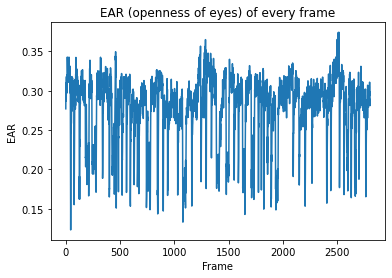

In [11]:
# calculate ear by averaging left and right ear
ear = ((np.array(left_ears) + np.array(right_ears)) / 2).tolist()

x_values = range(len(ear))
# plt.plot(x_values, left_ears)
# plt.plot(x_values, right_ears)
# plt.show()

plt.title("EAR (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('EAR')
plt.plot(x_values, ear)
plt.show()

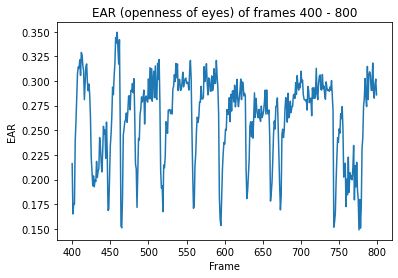

In [17]:
# looking more in depth at the ear graph
start_point = 400
end_point = 800

plt.plot(x_values[start_point:end_point], ear[start_point:end_point])
plt.title("EAR (openness of eyes) of frames " + str(start_point) + ' - ' + str(end_point))
plt.xlabel('Frame')
plt.ylabel('EAR')
plt.show()

In [19]:
# Finds eye-blinks given a sequence of EAR values and a treshhold.
def find_blinks(ear_values, treshhold):
    blink = False
    blinks = []
    blink_count = 0
    for i, ear in enumerate(ear_values):
        if ear < treshhold:
            if blink == False:
                blink_count +=1
                start = i
            blink = True
        else:
            if blink == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                blinks.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            blink = False
    return blinks, blink_count

treshhold = 0.15
blinks, count = find_blinks(ear, treshhold)
print(blinks)
print(np.array(blinks)[:,2])
print(len(blinks))

[(847, 847, 1), (1085, 1085, 1), (1161, 1161, 1), (1934, 1934, 1)]
[1 1 1 1]
4


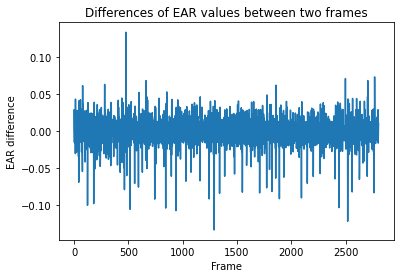

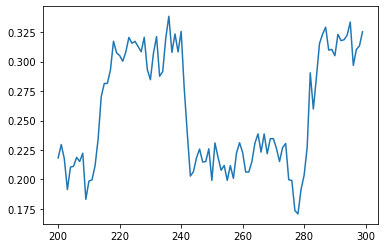

In [30]:
def take_differences(ear_values):
    diffs = []
    for i in range(len(ear_values) - 1):
        diff = ear_values[i+1] - ear_values[i]
        diffs.append(diff)
    return diffs

diffs = take_differences(ear)

x_values = range(len(diffs))
plt.plot(x_values, diffs)
plt.title("Differences of EAR values between two frames")
plt.xlabel('Frame')
plt.ylabel('EAR difference')
plt.show()

x_values = range(len(ear))
plt.plot(x_values[200:300], ear[200:300])
plt.show()

## Deleted code
### Haar cascade loop

In [73]:
# #path = 'test_frames/frame1030.jpg'
# frame_start = 0
# frame_end = 2804
# frames = range(frame_start, frame_end + 1)
# no_face_count = 0

# for frame in frames:
#     path = '../test_frames/frame' + str(frame) + '.jpg'
#     test_img, gray, rects = load_image_haar(path, show=False)
#     if len(rects) > 1:
#         print('multiple faces')
#         print(frame)
#         print(rects)
#         # The predicted faces are boxes (same width and height). The last two values correspond to these.
#         # So by just checking which is higher, I can find the correct face
#         if rects[0][2] > rects[1][2]:
#             face = rects[0]
#         else:
#             face = rects[1]
#         fX, fY, fW, fH = face[0],face[1], face[2], face[3]    
#         faceROI = gray[fY:fY+ fH, fX:fX + fW]
#         plt.imshow(faceROI, cmap='gray')
#         plt.show()
#         continue
# #     face = rects[0]
# #     fX, fY, fW, fH = face[0],face[1], face[2], face[3]    
# #     faceROI = gray[fY:fY+ fH, fX:fX + fW]
# #     plt.imshow(faceROI, cmap='gray')
# #     plt.show()
# print("Number of no face frames: ", no_face_count)


In [74]:
# # draw the face bounding box on the original rgb image, and show 
# bl_corner = (rects[0].bl_corner().x, rects[0].bl_corner().y)
# tr_corner = (rects[0].tr_corner().x, rects[0].tr_corner().y)
# image_rect = cv2.rectangle(test_image, bl_corner, tr_corner, (255,0,0), 2)
# plt.imshow(image_rect)
# plt.show()